<a href="https://colab.research.google.com/github/StephenSpicer/Unit_02_Clone/blob/master/Stephen_Lupsha_assignment_224.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Alright, this is an attempt to clean up the previous notebooks from the kaggle submissions and take a stab at K-Folds and our new modeling instruction from 01_20_2021

In [1]:

import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

     |████████████████████████████████| 81kB 6.3MB/s 


In [2]:
# better get all my importing done, and the data path - nicholas likes to call this the preamble cell. 

%%capture

#First, I'll do the SKLearn and model pipeline imports. 
import category_encoders as ce
from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.tree import plot_tree

# Next, I'll do the regular stuff we usually need. 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



In [ ]:
# # Wrangle function from ME and My Assignments :


# def wrangle(df):
#   #Make copy keep original in memory
#   df = df.copy()
#   #DropRecordedBy(ConstantValue)
#   df.drop(columns=['recorded_by'], inplace=True)
#   #HCCV
#   drop_cols = [col for col in df.select_dtypes('object').columns
#                if df[col].nunique() >100]
#   df.drop(columns=drop_cols, inplace=True)
#   # Drop repeat ROWS
#   #df.drop_duplicates(inplace=True)
#   # Datetime error - Remember to ask about the other methods for changing date so it works in models. 
#   #print('Breakpoint 1:')
 
#   df['pump_age'] = df['date_recorded'].dt.year - df['construction_year'] # this feature will tell us how old each pump is...
#   #print('Breakpoint 2:')
#   df['date_recorded'] = df['date_recorded'].dt.year
#   # Drop repeat COLUMNS
#   df.drop(columns=['quantity_group', 'extraction_type_group'], inplace=True)
#   #DropNA / features with lots of NA val (with threshold! '_' for comma, pretty cool...)
#   df.dropna(axis=1, thresh=7_000, inplace=True)
#   return df

In [20]:
# WRANGLE FUNCTION from SiSi:
# we're gonna come back in here and slash some columns I think. maybe. 


def wrangle(df):
  # Make a copy
  df = df.copy()

  # Drop repeat rows (observations)
  df.drop_duplicates(inplace=True)

  # Drop repeat columns (features)
  df.drop(columns=['quantity_group', 'extraction_type_group'], inplace=True)

  # Drop constant features
  df.drop(columns=['recorded_by'], inplace=True)

  # feature engineering
  df['pump_age'] = df['date_recorded'].dt.year - df['construction_year']
  df['date_recorded'] = df['date_recorded'].dt.year

  # drop datetime column
  df.drop(columns='date_recorded', inplace=True)

  # high-cardinality
  drop_cols = [col for col in df.select_dtypes('object').columns
               if df[col].nunique() > 100]
  df.drop(columns=drop_cols, inplace=True)

  # Drop features with lots of NaN values
  df.dropna(axis=1, thresh=len(df)*0.8, inplace=True)

  return df

In [21]:
# now we need our data, and we need a wrangle it... might as well get our test data while we are at it. 

# Import and clean TRAINING dataset
df = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv',
                          parse_dates=['date_recorded'],
                          na_values=[0, -2.000000e-08]), 
              pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv')).set_index('id')

df = wrangle(df)

# Import and clean TEST dataset
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv',
            parse_dates=['date_recorded'],
            na_values=[0, -2.000000e-08],
            index_col='id')

# better wrangle that X_test too. 
test = wrangle(test)

In [22]:
# Split train into train & val. Make val the same size as test.
target = 'status_group'
train, val = train_test_split(df, test_size=len(test),  
                              stratify=df[target], random_state=42)

# Arrange data into X features matrix and y target vector
X_train = df.drop(columns=target)
y_train = df[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test


#printing
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print()
print('X_val shape: ', X_val.shape)
print('y_val shape: ', y_val.shape)
print()
print('X_test shape: ', X_test.shape)


X_train shape:  (59363, 23)
y_train shape:  (59363,)

X_val shape:  (14358, 23)
y_val shape:  (14358,)

X_test shape:  (14358, 23)


In [ ]:
# # making X_train and y_train (splitting target vector from feature matrix)

# X_train = df.drop(['status_group'], axis=1)
# y_train = df['status_group']



 
## my wrangle gives a lot more columns than sisi's does so I'm gonna go with hers for now. 

In [23]:
# Baseline Accuracy

print('Baseline Accuracy:', df['status_group'].value_counts(normalize=True).max())

Baseline Accuracy: 0.5430487003689166


# Models : Logistic regression (classification) :


In [ ]:
lr = make_pipeline(OneHotEncoder(),
                   StandardScaler(),
                   SimpleImputer(),
                   LogisticRegression(max_iter=1000))

In [ ]:
# cross validation

%%time
lr_cvs = cross_val_score(lr, X_train, y_train, cv=5, n_jobs=-1)

CPU times: user 532 ms, sys: 41.7 ms, total: 574 ms
Wall time: 36 s


# we really don't need the above, because we are interested in classification today - but it's there just in case we get extra curious... 

In [ ]:
# let's visualize before we tune. 
print("logistic regression:")
print("cross validation score series is", lr_cvs)
print("cross validation score mean is", lr_cvs.mean())
print("cross validation score standard deviation is", lr_cvs.std())

logistic regression:
cross validation score series is [0.73056515 0.72989135 0.7297229  0.72548854 0.73399596]
cross validation score mean is 0.7299327799966537
cross validation score standard deviation is 0.0027094756141843603



# Now, with a Random Forest Classifier:

In [24]:
# random forest. we can tune parameteres here when we scroll back up. 

rf = make_pipeline(
    #FunctionTransformer(wrangle, validate=False), 
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.994915726424293


In [ ]:
# Be careful, 17min on this...
# now, the random forest cross validation :
# %%time
# rf_cvs = cross_val_score(rf, X_train, y_train, cv=5, n_jobs=-1)

CPU times: user 470 ms, sys: 17.5 ms, total: 487 ms
Wall time: 8.88 s


In [ ]:
# as before, these will change as we tune... 
print("random forest classifier:")
print("cross validation score series is", rf_cvs)
print("cross validation score mean is", rf_cvs.mean())
print("cross validation score standard deviation is", rf_cvs.std())

random forest classifier:
cross validation score series is [0.79002779 0.78497431 0.78943822 0.78765162 0.78394542]
cross validation score mean is 0.7872074723664625
cross validation score standard deviation is 0.002398154606898564


# Tuning

*Params:* 
## n_estimators: 20 to 60
## max_depth: 10 to 20
## max_samples: 0.3 to 0.6
## max_features: 5 to 20

# GridSearchCV()

In [ ]:
# setting up random forests with K Folds.
# we add 1 to the range values because it is not inclusive - so we cover our bases there. 
# dictionaries have key values - these three strings are critical for the function, in this case gridsearch... these are parameters. 
paras = {'randomforestclassifier__n_estimators': np.arange(55, 66, 5), 
         'randomforestclassifier__max_depth': np.arange(10, 31, 10),
         #'randomforestclassifier__max_samples': np.arange(0.3, 0.51, 0.1),
         'randomforestclassifier__max_features': np.arange(20, 26, 2)}

# random forest grid search. 

rf_gs = GridSearchCV(rf, paras, cv=5, n_jobs=-1, verbose=1)

In [ ]:
# fitting Grid Search Cross Validation. 
%%time
rf_gs.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 17.1min finished


CPU times: user 33.5 s, sys: 541 ms, total: 34.1 s
Wall time: 17min 29s


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('ordinalencoder',
                                        OrdinalEncoder(cols=None,
                                                       drop_invariant=False,
                                                       handle_missing='value',
                                                       handle_unknown='value',
                                                       mapping=None,
                                                       return_df=True,
                                                       verbose=0)),
                                       ('simpleimputer',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                                                      missing_values=nan,
          

In [ ]:
rf_gs.best_params_

{'randomforestclassifier__max_depth': 20,
 'randomforestclassifier__max_features': 20,
 'randomforestclassifier__n_estimators': 60}

In [ ]:
# SiSi's trick : make the results into a dataframe:
pd.DataFrame(rf_gs.cv_results_).sort_values(by='mean_test_score', ascending=False).T

,20,14,17,19,23,16,13,11,10,22,12,15,26,18,21,25,9,24,3,6,8,7,5,4,0,2,1
mean_fit_time,3.47986,4.54398,5.47093,2.52475,4.73449,3.83736,3.2692,3.33103,2.47125,3.31362,1.96721,2.2107,5.61727,1.60447,2.06211,4.0388,1.55332,2.40029,1.55721,1.72035,3.77153,2.79931,3.24611,2.45931,1.25236,2.55326,1.93133
std_fit_time,0.0657624,0.0560768,0.126793,0.113363,0.162563,0.0607438,0.0761688,0.0259563,0.0211112,0.0433921,0.0229593,0.0532144,0.164098,0.0517444,0.0270411,0.0843884,0.0281209,0.0386596,0.0283926,0.0519873,0.138282,0.0505067,0.0199166,0.0416256,0.0351566,0.097328,0.0645342
mean_score_time,0.32831,0.32851,0.337545,0.233262,0.359213,0.263119,0.257427,0.309761,0.252326,0.260566,0.171352,0.160747,0.353945,0.172332,0.180332,0.275162,0.192447,0.178032,0.136421,0.137489,0.210614,0.177624,0.213516,0.178876,0.133886,0.223093,0.161502
std_score_time,0.0151846,0.0077694,0.0116101,0.0271522,0.00657501,0.00221586,0.00720391,0.00340283,0.0159052,0.0103283,0.00113367,0.0282804,0.0306697,0.0182057,0.00453715,0.00536707,0.031363,0.0247574,0.00519445,0.00241335,0.0261821,0.0111767,0.0176827,0.0019013,0.00702331,0.00670262,0.0222509
param_randomforestclassifier__max_depth,30,20,20,30,30,20,20,20,20,30,20,20,30,30,30,30,20,30,10,10,10,10,10,10,10,10,10
param_randomforestclassifier__max_samples,0.3,0.5,0.7,0.3,0.5,0.7,0.5,0.3,0.3,0.5,0.5,0.7,0.7,0.3,0.5,0.7,0.3,0.7,0.5,0.7,0.7,0.7,0.5,0.5,0.3,0.3,0.3
param_randomforestclassifier__n_estimators,60,60,60,40,60,40,40,60,40,40,20,20,60,20,20,40,20,20,20,20,60,40,60,40,20,60,40
params,"{'randomforestclassifier__max_depth': 30, 'ran...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': 30, 'ran...","{'randomforestclassifier__max_depth': 30, 'ran...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': 30, 'ran...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': 30, 'ran...","{'randomforestclassifier__max_depth': 30, 'ran...","{'randomforestclassifier__max_depth': 30, 'ran...","{'randomforestclassifier__max_depth': 30, 'ran...","{'randomforestclassifier__max_depth': 20, 'ran...","{'randomforestclassifier__max_depth': 30, 'ran...","{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': 10, 'ran...","{'randomforestclassifier__max_depth': 10, 'ran..."
split0_test_score,0.800387,0.801398,0.803588,0.798787,0.80123,0.798871,0.79845,0.798366,0.799798,0.797103,0.796429,0.796008,0.795839,0.794576,0.794492,0.793397,0.790617,0.791123,0.763076,0.764676,0.765518,0.764929,0.762486,0.76316,0.761139,0.762234,0.760044
split1_test_score,0.798366,0.797692,0.798787,0.798787,0.795587,0.795334,0.799629,0.795502,0.795081,0.796008,0.791965,0.792049,0.792302,0.790786,0.791544,0.788764,0.789775,0.79028,0.743199,0.744378,0.740672,0.738566,0.739914,0.739072,0.738145,0.737724,0.738988


# Random Search cross-validation:

In [ ]:
# random forest random search. 
%%time
rf_rs = RandomizedSearchCV(rf, param_distributions=paras, n_iter=3, cv=5, n_jobs=-1, verbose=1)


CPU times: user 24 µs, sys: 0 ns, total: 24 µs
Wall time: 28.1 µs


In [ ]:
%%time
rf_rs.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   19.9s finished


CPU times: user 3.33 s, sys: 70.5 ms, total: 3.4 s
Wall time: 22.2 s


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            fill_value=None,


In [ ]:
rf_rs.best_params_

{'randomforestclassifier__max_depth': 30,
 'randomforestclassifier__max_samples': 0.3,
 'randomforestclassifier__n_estimators': 40}

In [ ]:
rf_gs.best_score_

0.7968261756328148

In [ ]:
rf_rs.best_score_

0.797837046693408

In [ ]:
y_pred1 = rf_rs.predict(X_test)

array(['non functional', 'functional', 'functional', ..., 'functional',
       'functional', 'non functional'], dtype=object)

In [ ]:
y_pred2 = rf_gs.predict(X_test)

In [ ]:
data = {'id': X_test.index, 'status_group': y_pred2}
submission3 = pd.DataFrame(data)
submission3.to_csv('kaggle_submission3.csv', index=False)

In [ ]:
submission3.head()

,id,status_group
0,50785,non functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


# Moving into Confusion Matrix


## this is resetting df, so be careful returning to your above cells, ok?

In [25]:
df['status_group'].value_counts()

functional                 32237
non functional             22812
functional needs repair     4314
Name: status_group, dtype: int64

In [26]:
df['needs_to_repair'] = df['status_group'].apply(lambda x : 0 if x == 'functional' else 1)

In [28]:
X = df.drop(['needs_to_repair', 'status_group'], axis=1)
y = df['needs_to_repair']

In [29]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
rf.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_type', 'source_class',
                                      'waterpoint_type',
                                      'waterpoint_type_group...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                 

In [32]:
y_pred = rf.predict(X_val)

In [33]:
accuracy_score(y_val, y_pred)

0.8130211404025941

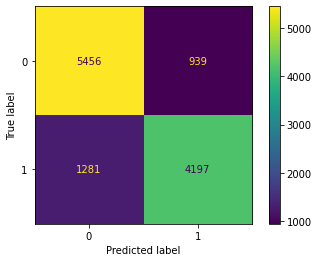

In [35]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(rf, X_val, y_val, values_format='.0f')

In [37]:
from sklearn.metrics import precision_score
precision_score(y_val, y_pred)

0.8171728971962616

In [38]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred, digits=6))

              precision    recall  f1-score   support

           0   0.809856  0.853167  0.830947      6395
           1   0.817173  0.766156  0.790842      5478

    accuracy                       0.813021     11873
   macro avg   0.813514  0.809661  0.810895     11873
weighted avg   0.813232  0.813021  0.812444     11873



In [41]:
rf.predict_proba(X_val)
y_pred_proba = rf.predict_proba(X_val)[:,-1]

In [43]:
y_pred


array([1, 1, 0, ..., 1, 0, 0])

In [42]:
y_pred_proba

array([0.94, 0.56, 0.32, ..., 0.99, 0.01, 0.24])

In [44]:
from ipywidgets import interact, fixed
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def my_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

def set_threshold(y_true, y_pred_proba, threshold=0.5):
    y_pred = y_pred_proba > threshold
    ax = sns.distplot(y_pred_proba)
    ax.axvline(threshold, color='red')
    plt.show()
    print(classification_report(y_true, y_pred))
    my_confusion_matrix(y_true, y_pred)

interact(set_threshold, 
         y_true=fixed(y_val), 
         y_pred_proba=fixed(y_pred_proba), 
         threshold=(0, 1, 0.02));

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

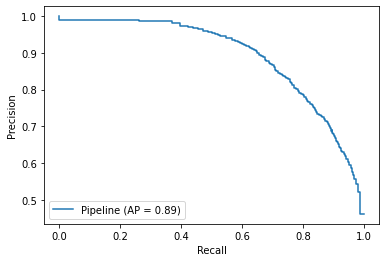

In [46]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
plot_precision_recall_curve(rf, X_val, y_val)

In [47]:
# Use scikit-learn to calculate the area under the curve.
# acronym is for Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC)
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, y_pred_proba)

0.8924409700783373